# 一个深度学习项目的流程：
准备数据 -> 加载数据 -> 定义模型架构 -> 将数据输入模型 -> 计算损失 -> 反向传播 ->评估模型

每一步做好解耦，可以快速实现在一个框架下训练不同的模型或者是不同的数据集。


## 数据管理器：

负责数据的获取、预处理变换及批量加载。该模块对模型结构一无所知，仅保证输出符合 PyTorch 的标准张量格式。

In [ ]:
# ============================================================
# 模块 1：数据管理器
# 职责：只负责数据的下载、预处理和加载。不关心模型长什么样。
# ============================================================
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class DataManager:
    def __init__(self, batch_size=64):
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
    def get_loaders(self):
        # 下载数据
        train_data = datasets.MNIST('./data', train=True, download=True, transform=self.transform)
        test_data = datasets.MNIST('./data', train=False, transform=self.transform)
        
        # 封装成加载器
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)
        
        print(f"[DataManager] 数据准备完毕: 训练集 {len(train_data)} 张, 测试集 {len(test_data)} 张")
        return train_loader, test_loader





# 网络架构模块

定义神经网络的拓扑结构与前向传播逻辑。该模块不包含数据加载逻辑，亦不参与训练参数的配置（如学习率、优化器选择）。

In [ ]:
# ============================================================
# 模块 2：神经网络模型
# 职责：只定义网络结构。不关心数据从哪来，也不关心训练循环怎么写。
# ============================================================
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 简单的卷积层
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# 训练引擎模块
封装训练循环、优化器配置及评估逻辑。该模块接收模型实例与数据迭代器作为输入，实现了训练过程与具体模型定义的分离。

In [ ]:
# ============================================================
# 模块 3：训练引擎
# 职责：负责执行训练循环。
# ============================================================
import torch.optim as optim

class Trainer:
    def __init__(self, model, device='cpu', lr=0.01):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        
    def train_epoch(self, train_loader, epoch_idx):
        self.model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            
            # 标准训练五步曲
            self.optimizer.zero_grad()   # 1. 梯度清零
            output = self.model(data)    # 2. 前向传播
            loss = self.criterion(output, target) # 3. 计算损失
            loss.backward()              # 4. 反向传播
            self.optimizer.step()        # 5. 更新参数
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f"  [Trainer] Epoch {epoch_idx} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")
        
        return total_loss / len(train_loader)

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                pred = output.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)
        
        acc = 100. * correct / total
        print(f"[Trainer] 测试准确率: {acc:.2f}%")
        return acc


我们现在调用数据接口加载一批数据并可视化

[DataManager] 数据准备完毕: 训练集 60000 张, 测试集 10000 张
加载的 Batch 形状: torch.Size([32, 1, 28, 28])


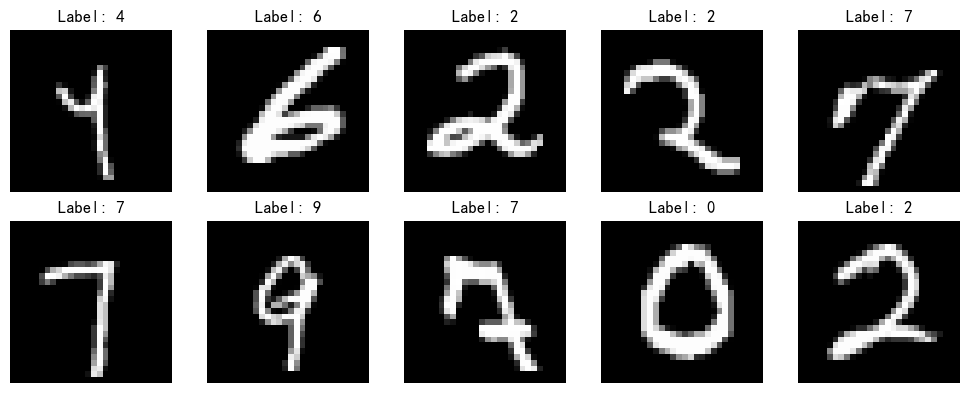

In [ ]:
import matplotlib.pyplot as plt
import torch

data_manager = DataManager(batch_size=32) 
train_loader, _ = data_manager.get_loaders()

# 2. 调用接口加载一批数据
images, labels = next(iter(train_loader))

# 3. 可视化
print(f"加载的 Batch 形状: {images.shape}")

# 创建画布
fig = plt.figure(figsize=(10, 4))
for idx in range(10): # 展示前10张图片
    ax = fig.add_subplot(2, 5, idx + 1)
    
    # Tensor 格式转换: (C, H, W) -> (H, W, C)
    # MNIST 是单通道灰度图，使用 squeeze 去掉通道维度
    img = images[idx].squeeze()
    
    # 显示图片 (反归一化可选，这里直接显示 Tensor 值，Matplotlib 会自动映射颜色)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[idx].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# 业务流程组装
演示如何将上述模块组装为完整的训练流程。得益于解耦设计，业务逻辑层代码简洁明了，仅负责协调各模块实例。

In [ ]:
import torch

# 1. 配置参数
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 2 
print("🚀 开始组装流程...")

data_manager = DataManager(batch_size=64)
model = SimpleCNN()
trainer = Trainer(model, device=DEVICE, lr=0.001)

train_loader, test_loader = data_manager.get_loaders()

# 4. 开始训练循环
print("\n🔥 开始训练...")
for epoch in range(1, EPOCHS + 1):
    avg_loss = trainer.train_epoch(train_loader, epoch)
    print(f"Epoch {epoch} 平均损失: {avg_loss:.4f}")

# 5. 评估结果
print("\n📊 最终评估...")
trainer.evaluate(test_loader)



# 替换模型
现在我们尝试替换掉model,我们先定义一个ResNet:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# 定义 ResNet 模块
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(BasicBlock, 32, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 64, 2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        return self.fc(out)




可以看到我们只需要重新实例化一个model并放入trainer中即可,其他代码不用修改

In [ ]:
# ============================================================
# 组装流程：仅替换模型实例
# ============================================================
print("🚀 [Experiment] Switching to ResNet...")

new_model = ResNet() # 实例化新模型
# DataManager 与 Trainer 逻辑复用
trainer = Trainer(new_model, device=DEVICE, lr=0.001)
trainer.train_epoch(train_loader, epoch_idx=1)
trainer.evaluate(test_loader)

# 替换数据集
现在将手写数字数据集替换为fashion_mnist


In [ ]:
from torchvision import datasets

# 定义新的数据管理器
class FashionDataManager:
    def __init__(self, batch_size=64):
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)) 
        ])
        
    def get_loaders(self):
        train_data = datasets.FashionMNIST('./fashion_data', train=True, download=True, transform=self.transform)
        test_data = datasets.FashionMNIST('./fashion_data', train=False, transform=self.transform)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)
        print(f"[FashionDataManager] Data Ready -> Train: {len(train_data)}")
        return train_loader, test_loader




同理,我们读取一批数据并可视化

[FashionDataManager] Data Ready -> Train: 60000
加载的 Batch 形状: torch.Size([64, 1, 28, 28])


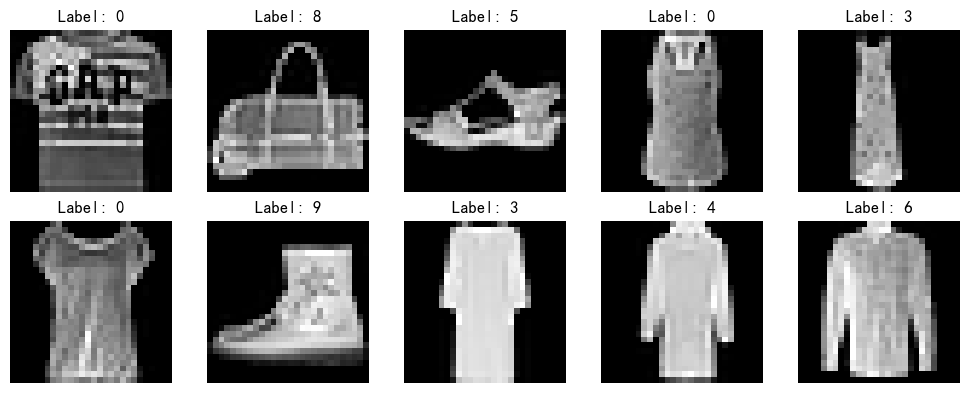

In [22]:
import matplotlib.pyplot as plt
import torch

# 1. 获取数据 (复用之前的 DataManager)
# 注意：如果之前已经实例化过 data_manager，可以直接使用，无需重新实例化
train_loader, _ = fashion_manager.get_loaders()

# 2. 调用接口加载一批数据
images, labels = next(iter(train_loader))

# 3. 可视化
print(f"加载的 Batch 形状: {images.shape}")

# 创建画布
fig = plt.figure(figsize=(10, 4))
for idx in range(10): # 展示前10张图片
    ax = fig.add_subplot(2, 5, idx + 1)
    
    # Tensor 格式转换: (C, H, W) -> (H, W, C)
    # MNIST 是单通道灰度图，使用 squeeze 去掉通道维度
    img = images[idx].squeeze()
    
    # 显示图片 (反归一化可选，这里直接显示 Tensor 值，Matplotlib 会自动映射颜色)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[idx].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()


重新组装:

In [ ]:
# ============================================================
# 组装流程：仅替换数据源
# ============================================================

# 模型复用 
model = SimpleCNN() 
fashion_manager = FashionDataManager(batch_size=64)
train_loader, test_loader = fashion_manager.get_loaders()

trainer = Trainer(model, device=DEVICE, lr=0.01)
trainer.train_epoch(train_loader, epoch_idx=1)
trainer.evaluate(test_loader)